wandb: Currently logged in as: mrsagarbiswas (mrsagarbiswas-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 01 | Train Loss: 2.9512 | Time: 93.3s
Epoch 02 | Train Loss: 1.9913 | Time: 91.6s
Epoch 03 | Train Loss: 1.4171 | Time: 95.8s
Epoch 04 | Train Loss: 1.1918 | Time: 92.4s
Epoch 05 | Train Loss: 1.0611 | Time: 91.3s
Epoch 06 | Train Loss: 0.9713 | Time: 91.4s
Epoch 07 | Train Loss: 0.9105 | Time: 91.5s
Epoch 08 | Train Loss: 0.8561 | Time: 94.3s
Epoch 09 | Train Loss: 0.8074 | Time: 92.7s
Epoch 10 | Train Loss: 0.7720 | Time: 92.6s
Epoch 11 | Train Loss: 0.7402 | Time: 91.9s
Epoch 12 | Train Loss: 0.7179 | Time: 91.7s
Epoch 13 | Train Loss: 0.6898 | Time: 91.4s
Epoch 14 | Train Loss: 0.6742 | Time: 91.7s
Epoch 15 | Train Loss: 0.6549 | Time: 92.2s

Batched evaluating on full test set…


Test Eval:   0%|          | 1/9228 [00:00<21:11,  7.26it/s]<ipython-input-1-a07a8444c835>:512: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  heatmaps.append((src_chars, true_chars, torch.tensor(attentions[global_i])))
Test Eval: 100%|██████████| 9228/9228 [00:03<00:00, 2383.43it/s]


Overall Test Character Accuracy: 0.7116
Overall Test Word Accuracy: 0.3601


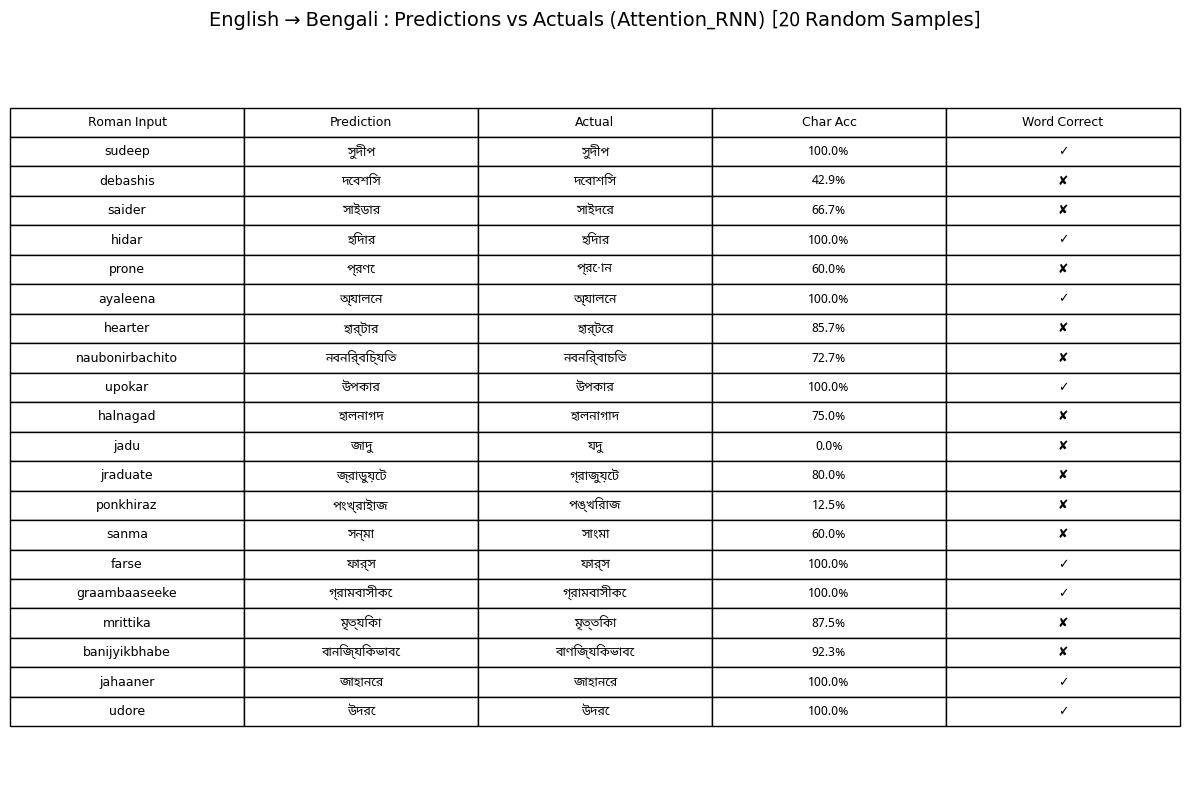

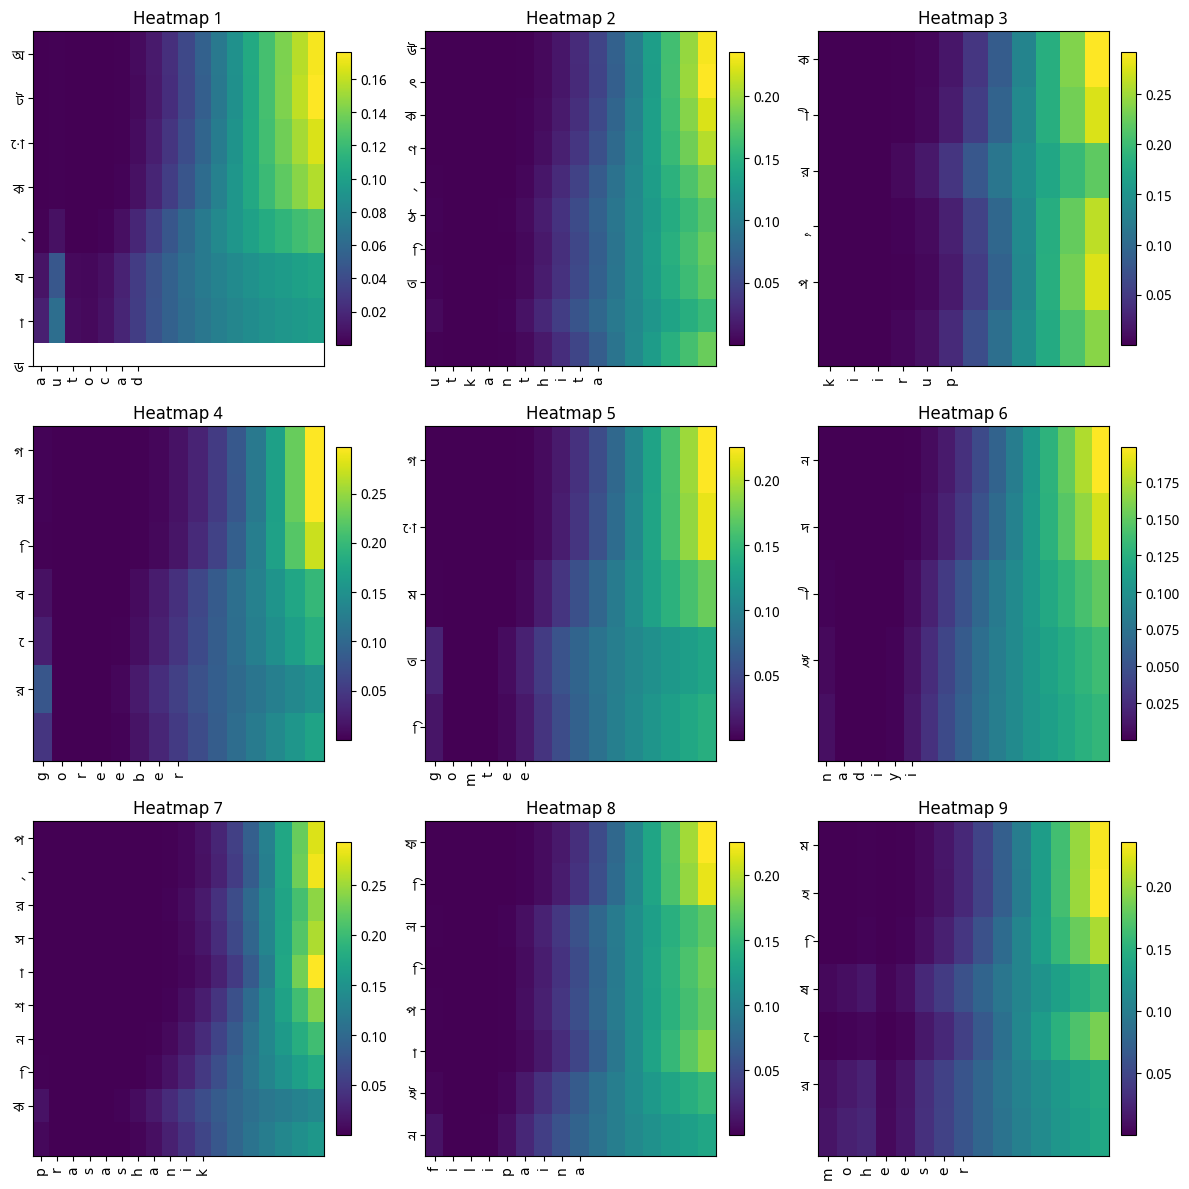

In [1]:
# -*- coding: utf-8 -*-
"""Attention_RNN_on_Test_Data.py

Modified from Vanilla_RNN_on_Test_Data to include Bahdanau attention, log test word/char accuracy to Weights & Biases,
batched greedy decode with progress bar, evaluate over all test inputs, store all predictions, plot 20 random samples table,
and display 3×3 random heatmaps.
"""

import os
import time
import random
import csv

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1) Download & register Noto Sans Bengali (for plotting later)
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansBengali/NotoSansBengali-Regular.ttf \
    -O /usr/share/fonts/truetype/NotoSansBengali-Regular.ttf
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/NotoSansBengali-Regular.ttf')

# 2) Configure Matplotlib font stack
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Noto Sans Bengali', 'DejaVu Sans']

# -------------------
# --- Vocab & Data ---
# -------------------
class CharVocab:
    def __init__(self, filepaths):
        self.rom_char2idx = {}
        self.dev_char2idx = {}
        self.rom_idx2char = {}
        self.dev_idx2char = {}
        self._build_vocab(filepaths)

    def _build_vocab(self, filepaths):
        rom_chars, dev_chars = set(), set()
        for fp in filepaths:
            with open(fp, "r", encoding="utf-8") as f:
                reader = csv.reader(f, delimiter="\t")
                for row in reader:
                    if len(row) < 2:
                        continue
                    dev, rom = row[0].strip(), row[1].strip()
                    if dev and rom:
                        rom_chars.update(rom)
                        dev_chars.update(dev)
        PAD, SOS, EOS = "<pad>", "<sos>", "<eos>"
        all_rom = [PAD, SOS, EOS] + sorted(rom_chars)
        all_dev = [PAD, SOS, EOS] + sorted(dev_chars)
        for i, ch in enumerate(all_rom):
            self.rom_char2idx[ch] = i
            self.rom_idx2char[i] = ch
        for i, ch in enumerate(all_dev):
            self.dev_char2idx[ch] = i
            self.dev_idx2char[i] = ch

        # store special indices
        self.rom_pad_idx = self.rom_char2idx[PAD]
        self.rom_sos_idx = self.rom_char2idx[SOS]
        self.rom_eos_idx = self.rom_char2idx[EOS]
        self.dev_pad_idx = self.dev_char2idx[PAD]
        self.dev_sos_idx = self.dev_char2idx[SOS]
        self.dev_eos_idx = self.dev_char2idx[EOS]

    @property
    def rom_vocab_size(self):
        return len(self.rom_char2idx)

    @property
    def dev_vocab_size(self):
        return len(self.dev_char2idx)

    def roman_to_indices(self, s):
        return [self.rom_sos_idx] + [
            self.rom_char2idx.get(ch, self.rom_pad_idx) for ch in s
        ] + [self.rom_eos_idx]

    def dev_to_indices(self, s):
        return [self.dev_sos_idx] + [
            self.dev_char2idx.get(ch, self.dev_pad_idx) for ch in s
        ] + [self.dev_eos_idx]

    def indices_to_dev(self, idxs):
        return "".join(
            self.dev_idx2char[i]
            for i in idxs
            if i not in (self.dev_sos_idx, self.dev_eos_idx, self.dev_pad_idx)
        )


def read_tsv(path):
    pairs = []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if len(row) < 2:
                continue
            dev, rom = row[0].strip(), row[1].strip()
            if dev and rom:
                pairs.append((rom, dev))
    return pairs

class TransliterationDataset(Dataset):
    def __init__(self, filepath, vocab):
        self.pairs = read_tsv(filepath)
        self.vocab = vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rom, dev = self.pairs[idx]
        return (
            torch.tensor(self.vocab.roman_to_indices(rom), dtype=torch.long),
            torch.tensor(self.vocab.dev_to_indices(dev), dtype=torch.long),
        )

    @staticmethod
    def collate_fn(batch):
        roms, devs = zip(*batch)
        max_r, max_d = max(map(len, roms)), max(map(len, devs))
        rom_patches, dev_patches = [], []
        for r, d in zip(roms, devs):
            pad_r = torch.cat([r, r.new_full((max_r - len(r),), 0)])
            pad_d = torch.cat([d, d.new_full((max_d - len(d),), 0)])
            rom_patches.append(pad_r)
            dev_patches.append(pad_d)
        return torch.stack(rom_patches), torch.stack(dev_patches)

# -----------------------
# --- Attention Module ---
# -----------------------
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden[-1]: (batch, H)
        h = hidden[-1]
        seq_len = encoder_outputs.size(1)
        h_expanded = h.unsqueeze(1).repeat(1, seq_len, 1)  # (B, T, H)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(h_expanded)))  # (B, T, 1)
        attention_weights = torch.softmax(score.squeeze(2), dim=1)  # (B, T)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (B, H)
        return context, attention_weights

# -----------------------
# --- Model (Encoder) ---
# -----------------------
class Encoder(nn.Module):
    def __init__(self, inp_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(inp_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[self.cell]
        self.rnn = rnn_cls(
            emb_sz,
            hid_sz,
            num_layers=nl,
            batch_first=True,
            dropout=do if nl > 1 else 0.0,
        )
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, x):
        emb = self.embed(x)
        if self.cell == "LSTM":
            outputs, (h, c) = self.rnn(emb)
            return outputs, (h, c)
        else:
            outputs, h = self.rnn(emb)
            return outputs, h

# -----------------------
# --- Model (Decoder) ---
# -----------------------
class Decoder(nn.Module):
    def __init__(self, out_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(out_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[self.cell]
        self.rnn = rnn_cls(
            emb_sz + hid_sz,
            hid_sz,
            num_layers=nl,
            batch_first=True,
            dropout=do if nl > 1 else 0.0,
        )
        self.attention = BahdanauAttention(hid_sz)
        self.out = nn.Linear(hid_sz, out_sz)
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, tgt, hidden, cell, encoder_outputs, teacher_forcing_ratio=0.0):
        B, T = tgt.size()
        outputs = torch.zeros(B, T, self.out.out_features, device=tgt.device)
        input_step = tgt[:, 0]
        h, c = (hidden, cell) if self.cell == "LSTM" else (hidden, None)
        for t in range(1, T):
            emb = self.embed(input_step)  # (B, emb)
            context, _ = self.attention(h, encoder_outputs)  # (B, H)
            rnn_input = torch.cat([emb, context], dim=1).unsqueeze(1)  # (B,1, emb+H)
            if self.cell == "LSTM":
                out, (h, c) = self.rnn(rnn_input, (h, c))
            else:
                out, h = self.rnn(rnn_input, h)
                c = None
            logits = self.out(out.squeeze(1))  # (B, vocab)
            outputs[:, t] = logits
            teacher_force = random.random() < teacher_forcing_ratio
            next_input = tgt[:, t] if teacher_force else logits.argmax(1)
            input_step = next_input
        return outputs

# -------------------------------------
# --- Seq2Seq Wrapper ---
# -------------------------------------
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, device):
        super().__init__()
        self.encoder = enc
        self.decoder = dec
        self.device = device

    def forward(self, src, tgt, tf_ratio=0.5):
        if self.encoder.cell == "LSTM":
            enc_outputs, (h_n, c_n) = self.encoder(src)
        else:
            enc_outputs, h_n = self.encoder(src)
            c_n = None
        enc_layers = self.encoder.num_layers
        dec_layers = self.decoder.num_layers
        H = self.encoder.hidden_size
        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]
                c_dec = c_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, src.size(0), H, device=self.device)
                pad_c = torch.zeros(dec_layers - enc_layers, src.size(0), H, device=self.device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
                c_dec = torch.cat([pad_c, c_n], dim=0)
        else:
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, src.size(0), H, device=self.device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
            c_dec = None
        logits = self.decoder(tgt, h_dec, c_dec, enc_outputs, teacher_forcing_ratio=tf_ratio)
        return logits

    @torch.no_grad()
    def batch_greedy_decode(self, src_batch, max_len, sos, eos, heatmap_indices, idx_offset=0):
        """
        src_batch: (B, src_len)
        Returns:
          list of pred sequences (list of token lists),
          attention weights dict mapping global index to list of (timestep-attention arrays)
        """
        B, src_len = src_batch.size()
        device = self.device
        # Encode batch
        if self.encoder.cell == "LSTM":
            enc_outputs, (h_n, c_n) = self.encoder(src_batch)
        else:
            enc_outputs, h_n = self.encoder(src_batch)
            c_n = None
        enc_layers = self.encoder.num_layers
        dec_layers = self.decoder.num_layers
        H = self.encoder.hidden_size
        # Prepare initial decoder hidden/cell
        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]  # (L_dec, B, H)
                c_dec = c_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, B, H, device=device)
                pad_c = torch.zeros(dec_layers - enc_layers, B, H, device=device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
                c_dec = torch.cat([pad_c, c_n], dim=0)
        else:
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, B, H, device=device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
            c_dec = None
        # Initialize sequences, attention containers, done mask
        seqs = [[sos] for _ in range(B)]
        done = [False] * B
        attentions = {idx_offset + i: [] for i in range(B) if (idx_offset + i) in heatmap_indices}
        # Current input tokens
        current_tokens = torch.tensor([sos] * B, device=device)  # (B,)
        for _ in range(max_len):
            emb = self.decoder.embed(current_tokens).squeeze(1)  # (B, emb)
            context, attn_weights = self.decoder.attention(h_dec, enc_outputs)  # (B, H), (B, src_len)
            # Store attention for those in heatmap_indices
            for i in range(B):
                global_idx = idx_offset + i
                if global_idx in heatmap_indices and not done[i]:
                    attentions[global_idx].append(attn_weights[i].cpu().numpy())
            rnn_input = torch.cat([emb, context], dim=1).unsqueeze(1)  # (B,1, emb+H)
            if self.decoder.cell == "LSTM":
                out, (h_dec, c_dec) = self.decoder.rnn(rnn_input, (h_dec, c_dec))
            else:
                out, h_dec = self.decoder.rnn(rnn_input, h_dec)
            logits = self.decoder.out(out.squeeze(1))  # (B, vocab)
            next_tokens = logits.argmax(1)  # (B,)
            for i in range(B):
                if not done[i]:
                    token = next_tokens[i].item()
                    seqs[i].append(token)
                    if token == eos:
                        done[i] = True
            current_tokens = next_tokens
            if all(done):
                break
        return seqs, attentions

# -------------------------------------
# --- Training + Evaluation Function ---
# -------------------------------------
def train_and_evaluate(args):
    random.seed(42)
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    # Initialize W&B
    wandb.init(project="transliteration", name="Best_Model_Attention_RNN", config={
        "emb_size": args.emb_size,
        "hidden_size": args.hidden_size,
        "enc_layers": args.enc_layers,
        "dec_layers": args.dec_layers,
        "cell_type": args.cell_type,
        "dropout": args.dropout,
        "lr": args.lr,
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "tf_ratio": args.tf_ratio,
        "max_dev_len": args.max_dev_len,
    })

    paths = [args.train_file, args.dev_file, args.test_file]
    vocab = CharVocab(paths)

    train_dataset = TransliterationDataset(args.train_file, vocab)
    dev_dataset = TransliterationDataset(args.dev_file, vocab)
    test_dataset = TransliterationDataset(args.test_file, vocab)

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=2,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dev_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=2,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=TransliterationDataset.collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    enc = Encoder(
        vocab.rom_vocab_size,
        args.emb_size,
        args.hidden_size,
        args.enc_layers,
        args.cell_type,
        args.dropout,
    )
    dec = Decoder(
        vocab.dev_vocab_size,
        args.emb_size,
        args.hidden_size,
        args.dec_layers,
        args.cell_type,
        args.dropout,
    )
    model = Seq2Seq(enc, dec, device).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=vocab.dev_pad_idx)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

    best_path = "best_model_attn.pt"
    if os.path.exists(best_path):
        try:
            model.load_state_dict(torch.load(best_path, map_location=device))
        except RuntimeError:
            print("Checkpoint mismatch, training from scratch...")
    else:
        for epoch in range(1, args.epochs + 1):
            model.train()
            epoch_loss = 0.0
            start_time = time.time()
            for src, tgt in train_loader:
                src = src.to(device)
                tgt = tgt.to(device)
                optimizer.zero_grad()
                logits = model(src, tgt, args.tf_ratio)
                loss = criterion(
                    logits.view(-1, logits.size(-1)),
                    tgt.view(-1)
                )
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            wandb.log({"train_loss": avg_loss, "epoch": epoch})
            print(f"Epoch {epoch:02d} | Train Loss: {avg_loss:.4f} | Time: {time.time()-start_time:.1f}s")
        torch.save(model.state_dict(), best_path)

    # ----------------------
    # --- TEST & HEATMAPS ---
    # ----------------------
    print("\nBatched evaluating on test set…")
    model.eval()
    sos_idx = vocab.dev_sos_idx
    eos_idx = vocab.dev_eos_idx

    num_test = len(test_dataset)
    # sample 9 random indices for 3x3 heatmaps
    heatmap_indices = set(random.sample(range(num_test), min(9, num_test)))
    heatmaps = []
    all_records = []  # (roman, pred, true, char_acc, word_correct)

    total_chars = 0
    correct_chars = 0
    total_words = 0
    correct_words = 0

    # progress bar over number of examples
    with tqdm(total=num_test, desc="Test Eval") as pbar:
        idx_offset = 0
        for src_batch, tgt_batch in test_loader:
            B = src_batch.size(0)
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            # Batched decode
            seqs, attentions = model.batch_greedy_decode(
                src_batch, args.max_dev_len, sos_idx, eos_idx, heatmap_indices, idx_offset
            )
            # Process each example in batch
            for i in range(B):
                global_i = idx_offset + i
                # source word
                src_ids = src_batch[i].cpu().tolist()
                src_chars = [vocab.rom_idx2char[idx] for idx in src_ids if idx not in (vocab.rom_pad_idx, vocab.rom_sos_idx, vocab.rom_eos_idx)]
                roman = "".join(src_chars)

                # true word
                tgt_ids = tgt_batch[i].cpu().tolist()
                true_chars = [vocab.dev_idx2char[idx] for idx in tgt_ids if idx not in (vocab.dev_pad_idx, vocab.dev_sos_idx, vocab.dev_eos_idx)]
                true_word = "".join(true_chars)

                # predicted word
                pred_seq = seqs[i]
                pred_chars = []
                for idx_tok in pred_seq:
                    if idx_tok in (eos_idx, vocab.dev_sos_idx, vocab.dev_pad_idx):
                        continue
                    pred_chars.append(vocab.dev_idx2char[idx_tok])
                pred_word = "".join(pred_chars)

                # filter out whitespace
                true_filtered = [c for c in true_chars if not c.isspace()]
                pred_filtered = [c for c in pred_chars if not c.isspace()]

                # char accuracy
                matches = sum(1 for a, b in zip(pred_filtered, true_filtered) if a == b)
                if len(true_filtered) > 0:
                    ch_acc = matches / len(true_filtered)
                else:
                    ch_acc = 0.0
                total_chars += len(true_filtered)
                correct_chars += matches

                # word correctness
                word_correct = ("".join(pred_filtered) == "".join(true_filtered))
                total_words += 1
                if word_correct:
                    correct_words += 1

                all_records.append((roman, pred_word, true_word, ch_acc, word_correct))

                # store heatmap if needed
                if global_i in heatmap_indices:
                    heatmaps.append((src_chars, true_chars, torch.tensor(attentions[global_i])))

                pbar.update(1)
            idx_offset += B

    # overall accuracies
    overall_char_acc = correct_chars / total_chars if total_chars > 0 else 0.0
    overall_word_acc = correct_words / total_words if total_words > 0 else 0.0

    print(f"Overall Test Character Accuracy: {overall_char_acc:.4f}")
    print(f"Overall Test Word Accuracy: {overall_word_acc:.4f}")

    wandb.log({"test_char_acc": overall_char_acc, "test_word_acc": overall_word_acc})

    with open("predictions_attention.tsv", "w", encoding="utf-8") as f:
        writer = csv.writer(f, delimiter="\t")
        writer.writerow(["Roman_Input", "Predicted_Dev", "Gold_Dev", "Char_Accuracy", "Word_Correct"])
        for roman, pred_word, true_word, ch_acc, word_correct in all_records:
            # word_correct: True→1, False→0
            writer.writerow([roman, pred_word, true_word, f"{ch_acc:.4f}", int(word_correct)])

    print("Saved all predictions to predictions_attention.tsv")

    # ==============================
    # === Plot 20 Random Samples ===
    # ==============================
    samples = random.sample(all_records, min(20, len(all_records)))
    column_labels = ["Roman Input", "Prediction", "Actual", "Char Acc", "Word Correct"]
    cell_data = []
    for roman, pred, true, ch_acc, wd_corr in samples:
        cell_data.append([roman, pred, true, f"{ch_acc*100:.1f}%", "✓" if wd_corr else "✘"])

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis("off")
    ax.set_title("English → Bengali : Predictions vs Actuals (Attention_RNN) [20 Random Samples]", pad=20, fontsize=14)
    tbl = ax.table(cellText=cell_data, colLabels=column_labels, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.5)
    plt.tight_layout()
    plt.show()

    # ==============================
    # === Plot 3x3 Heatmaps ========
    # ==============================
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for idx, ax in enumerate(axes.flatten()):
        if idx < len(heatmaps):
            src_chars, true_chars, attn_matrix = heatmaps[idx]
            im = ax.imshow(attn_matrix.numpy(), aspect='auto', cmap='viridis')
            ax.set_xticks(range(len(src_chars)))
            ax.set_xticklabels(src_chars, rotation=90)
            ax.set_yticks(range(len(true_chars)))
            ax.set_yticklabels(true_chars)
            ax.set_title(f"Heatmap {idx+1}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    class Args:
        pass
    args = Args()
    args.train_file = "bn.translit.sampled.train.tsv"
    args.dev_file = "bn.translit.sampled.dev.tsv"
    args.test_file = "bn.translit.sampled.test.tsv"
    args.emb_size = 512
    args.hidden_size = 512
    args.enc_layers = 5
    args.dec_layers = 3
    args.cell_type = "GRU"
    args.dropout = 0.3
    args.lr = 1e-4
    args.batch_size = 128
    args.epochs = 15
    args.tf_ratio = 0.5
    args.max_dev_len = 32
    args.beam_size = 5
    train_and_evaluate(args)
